# Pytroch from Scratch

In [1]:
import math
import random

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
%matplotlib inline

In [2]:
class Value:
    
    def __init__(self, data, children=()):
        self.data = data
        self.grad = 0.0
        self._children = children
        self._backward = lambda *args: None
        
    def __repr__(self):
        return f"Value=({self.data})"
    
    def __add__(self, other):
        other = Value(other) if isinstance(other, (int, float)) else other
        
        out = Value(self.data + other.data, (self, other))
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = Value(other) if isinstance(other, (int, float)) else other
        
        out = Value(self.data * other.data, (self, other))

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __pow__(self, other):
        # needed some help here
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"

        out = Value(self.data ** other, (self,))

        def _backward():
            # weirdly I had to look this up lol
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * other ** -1
    
    def exp(self):
        out = Value(math.exp(self.data), (self,))
        
        def _backward():
            self.grad += out.data
        out._backward = _backward
            
        return out
    
    def tanh(self):
        # had to look up the tanh function and derivative 
        out = (self.exp() - (self * -1).exp()) / (self.exp() + (self * -1).exp())
        out._children = (self,)
        
        def _backward():
            # had to ask someone to figure out that I used parantheses in wrong place
            self.grad += (1 - out.data ** 2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        # topological sort
        visited = set()
        # forgot this line
        topo = []
        def build_topo(node):
            visited.add(node)
            for child in node._children:
                build_topo(child) if (child not in visited) else None
            # also forgot this line
            topo.append(node)
        build_topo(self)

        self.grad = 1
        for p in reversed(topo):
            p._backward()
   

In [3]:
# Testing    
a = Value(4.0)
b = Value(2.0)
c = Value(7.0)

d = a+b
e = c*d
res = e ** 2
res.backward()
(a.grad, b.grad, c.grad, d.grad, e.grad, res.grad)

(588.0, 588.0, 504.0, 588.0, 84.0, 1)

In [4]:
# testing automatic differentiation
h = 0.0001
a = Value(1.0)
r1 = a.tanh()

b = Value(1 + h)
r2 = b.tanh()

r1.grad = 1
r1.backward()
a.grad, (r2 - r1)/h

(0.4199743416140259, Value=(0.4199423576500827))

In [5]:
class Neuron:
    
    # wasn't sure how to initalize the weights
    def __init__(self, nin):
        self.w = [Value(random.uniform(-0.5, 0.5)) for _ in range(nin)]
        self.b = Value(random.uniform(-0.5,0.5))
        
    # had to look up the zip function
    def __call__(self, x):
        act = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()
        
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, inputs, outputs):
        self.neurons = [Neuron(inputs) for _ in range(outputs)]
        
    def __call__(self, x):
        out = [n(x) for n in self.neurons]

        # had to look up length 1 array handling
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    
    def __init__(self, layers):
        """
        
        :param layers: listlike, index 0 is data dimension, last index is output dimension, intermediary layers are in between. Example: [2, 3, 1] for a binary classifier of 2D datapoints with a 3D internal representation.
        """
        self.layers = [Layer(layer, layers[i+1]) for i, layer in enumerate(layers[:-1])]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
            
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [6]:
mlp1 = MLP([1,2,1])
len(mlp1.parameters())

7

In [7]:
mlp2 = MLP([1,2,1])
mlp2([1,2,3])

Value=(0.5187852168154413)

In [8]:
# andrejs training example
X = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
Y = [1.0, -1.0, -1.0, 1.0]

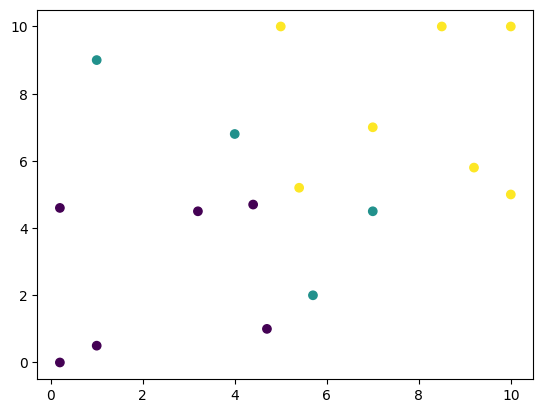

In [9]:
# Seconds training example
# Values with both values below 5 should be classified as 0, both above 5: 1 and otherwise 0.5
X = np.array([[1.0, 0.5], [4.4, 4.7], [0.2, 4.6], [4.7, 1], [0.2, 0.0], [3.2, 4.5], [5.7, 2], [4, 6.8], [7, 4.5], [1, 9], [9.2, 5.8], [8.5, 10.0], [10, 10], [7, 7], [10, 5], [5, 10], [5.4, 5.2]])
Y = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

# visualize the training data
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=Y)

In [39]:
# initialize up the model
model = MLP([2, 4, 4, 4, 1])

In [42]:
learning_rate = -0.01
epochs = 200
for k in range(epochs):
    # forward pass
    preds = [model(x) for x in X]
    loss = sum((pred - y) ** 2 for pred, y in zip(preds, Y))
    
    # backward pass
    for p in model.parameters():
        p.grad = 0
    loss.backward()
    
    # adjust parameters
    for p in model.parameters():
        p.data += p.grad * learning_rate
    
    print(k, loss) if k%10 == 0 else None

0 Value=(0.8653751593041357)
10 Value=(2.000753492466442)
20 Value=(0.9501842462349241)
30 Value=(0.9987718918044387)
40 Value=(1.0716753951793312)
50 Value=(0.8718019925868546)
60 Value=(0.804462892836217)
70 Value=(0.7764843656371966)
80 Value=(1.7741639685390598)
90 Value=(1.1642617524851862)
100 Value=(0.9701646947568774)
110 Value=(1.0584293648983945)
120 Value=(1.7821229224615402)
130 Value=(0.7694936140866615)
140 Value=(1.0709964949850963)
150 Value=(1.378556105511477)
160 Value=(0.659388233780074)
170 Value=(0.7985767127600389)
180 Value=(1.342929807277561)
190 Value=(0.5992428851261329)


In [49]:
model([5.2, 7])

Value=(0.8015418376724314)